# ДЗ 1
## Классический МЛ в NLP, вспомнить все!

В этом ДЗ будем работать с датасетом Men_Women_Shoes_Reviews https://www.kaggle.com/daishinkan002/men-women-shoes-reviews 
 

### **Задание 1**. 
Предсказать цену по описанию товара (для каждого товара)
### **Задание 2.** 
Предсказать оценку товара пользователем по его отзыву (для каждого отзыва)

т е 

Reviews - Contains up to 10 reviews of Shoe ( separated by '|| ')
exmpl - 


Reviews Rating -  Contains up to 10 corresponding reviews rating of Mobile ( separated by '|| ')
exmpl - 

## *Что нужно сделать в каждом задании:* 
1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) **1 балл**

2) подготовить данные (стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать... все, что покажется вам разумным относительно данных, но вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг. Хороший препроцессинг - разумный, в данном случае чем больше тем не всегда лучше) **1 балла**

3) векторизовать тексты (контекстуальные эммбединги пока что не берем, только BoW и TF-IDF) **0.5 балл**

4) сделать гридсерч по нескольким моделям (у нас 2 задания, классификация и регрессия), подобрать гиперпараметры, выбрать лучшую модель, рассказать, почему, на ваш взгляд,лучший результат показал лучший алгоритм **1 балл**

5) оценить и проанализировать качество лучших решений для каждой задачи (рассказать с чем ваша модель справляется хорошо, а где у нее "слабые места", можно ли как-то улучшить ваши результаты. Хороший анализ сопровождается графиками) **1,5 балла** 

Максимальная сумма баллов при выполнении 5 пунктов в 2 заданиях - 10

В тетрадке с первого занятия много дополнительной информации, которая может вам помочь, но все равно не стесняйтесь приходить с вопросами в чат курса. 

# общая часть анализа данных для двух заданий


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
df = pd.read_csv('/content/drive/My Drive/Shoes_Data.csv')
df.head(3)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


инфа по столбцам

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1230 non-null   object
 1   price                1230 non-null   object
 2   rating               1230 non-null   object
 3   total_reviews        1230 non-null   object
 4   product_description  1230 non-null   object
 5   reviews              1230 non-null   object
 6   reviews_rating       1230 non-null   object
 7   Shoe Type            1230 non-null   object
dtypes: object(8)
memory usage: 77.0+ KB


итак, мы знаем, что: в датасете 1230 строк, нет пропущенных значений, тип каждой колонки - строка

надо проверить в одной ли валюте указана цена товаров

In [38]:
df['currency'] = df['price'].str[0]
df['currency'].unique()

array(['₹'], dtype=object)

валюта одинакова, удалим этот столбец

переведем колонку с ценой в тип float

In [39]:
df.drop('currency', inplace=True, axis=1)
df['price'] = pd.to_numeric(df['price'].str[1:], downcast="float")

In [40]:
df.head(3)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,479.0,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,430.0,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


удалим полные дубликаты строк (если они есть)

In [41]:
df.drop_duplicates(inplace=True)
df.shape

(1015, 8)

теперь в датафрейме 1015 строк

In [42]:
df.to_csv('/content/drive/My Drive/my_shoes_data.csv', index=None)

# задание 1

Предсказать цену по описанию товара (для каждого товара)

1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) **1 балл**

In [33]:
df = pd.read_csv('/content/drive/My Drive/my_shoes_data.csv')

тк в этом задании просят предсказать цену только по описанию, уберем ненужные столбцы

также надо проверить не осталось ли дубликатов

In [34]:
df = df[['price',
         'product_description']]

In [35]:
df.drop_duplicates(inplace=True)
df.shape

(969, 2)

препроцессинг для колонки с описанием

In [36]:
from string import punctuation

! не хочется убирать из текстов, потому что это может нести некоторую информацию

In [37]:
punctuation = punctuation.strip("!")
punctuation += "...-"

In [38]:
punctuation

'"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~...-'

In [8]:
! pip install emoji

убираю

1) пунктуацию кроме !

2) повтор пробелов

3) non english characters, except emojis

In [39]:
import re
import emoji
emojis_set = set(emoji.UNICODE_EMOJI['en'].keys())

def delete_trash(text):
    for ch in punctuation:
        text = text.replace(ch, "")
    # delete non-english characters

    # например для "Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం" 
    # останется только "Nike"
    for ch in text:
        if not ch.isascii() and ch not in emojis_set:
            text = text.replace(ch, "")
    return re.sub("\s+", " ", text.strip())

In [40]:
df['without_punc'] = df['product_description'].apply(delete_trash)

генерация статистических фичей по описанию

In [41]:
df['description_len'] = df['without_punc'].apply(len)

df['num_of_tokens'] = df['without_punc'].apply(lambda x: len(x.split()))

df['num_of_caps'] = df['without_punc'].apply(lambda x: len([ch for ch in x if ch.isupper()]))

df['num_of_nonalpha'] = df['without_punc'].apply(lambda x: len([ch for ch in x if not ch.isalnum() and not ch == " "]))
# isalnum - checks if every symbol is number or letter

в num_of_nonalpha будут считаться "!" и emojis, посмотрим, есть ли они вообще:

In [42]:
df.num_of_nonalpha.unique()

array([ 0,  1,  2,  5,  4, 20, 13, 17,  3, 44])

удалить пустые строки из описания

In [43]:
df.shape

(969, 7)

In [44]:
df['without_punc'].replace('', np.nan, inplace=True)
df.dropna(subset=['without_punc'], inplace=True)

In [45]:
df.shape

(966, 7)

стоп слова и лемматизация

In [186]:
# Install spaCy (run in terminal/prompt)

!pip install spacy

# Download spaCy's  'en' Model
!spacy download en

     |████████████████████████████████| 12.0 MB 13.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [46]:
import spacy

def get_lemmas(text): # без цифр и стоп слов
    # nlp = spacy.load('en', disable=['parser', 'ner'])
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if token.text in ["no", "not"] \
                     or not token.is_stop and token.is_alpha])


In [47]:
nlp = spacy.load('en', disable=['parser', 'ner'])
df['lemmatized_isalpha'] = df['without_punc'].apply(get_lemmas)

In [48]:
df.drop(['product_description', 'without_punc'], inplace=True, axis=1)

In [49]:
df.head()

,price,description_len,num_of_tokens,num_of_caps,num_of_nonalpha,lemmatized_isalpha
0,279.0,220,35,9,0,elevate style classy pair run shoe house clymb...
1,479.0,76,14,2,0,product excellent pick ensure easy maintenance
2,430.0,390,70,7,0,flaunt stylish unique red casual shoe late fas...
3,499.0,564,99,100,0,robbie jones shoe design keep mind durability ...
4,499.0,1018,171,18,0,sparx spectacular range footwear house relaxo ...


In [50]:
df.to_csv('/content/drive/My Drive/shoes_for_regr.csv', index=None)

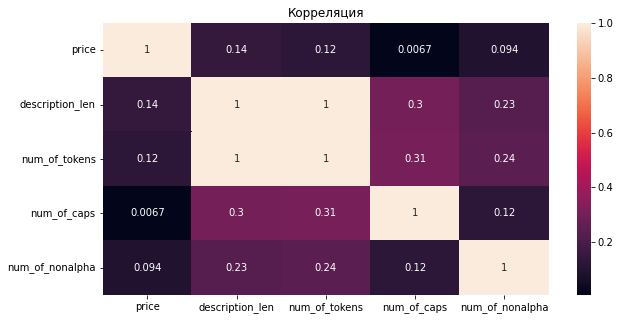

In [51]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=df[['price', 'description_len', 
                    'num_of_tokens', 'num_of_caps', 
                    'num_of_nonalpha']].corr(), 
            annot=True, ax=ax)
plt.title("Корреляция")
plt.show()

description_len и num_of_tokens сильно коррелированы, что логично, у остальных колонок все норм

кажется, что достаточно одной из этих колонок про длину описания, поэтому удалю одну из них, например num_of_tokens

In [52]:
df.drop(['num_of_tokens'], inplace=True, axis=1)


график для цены

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

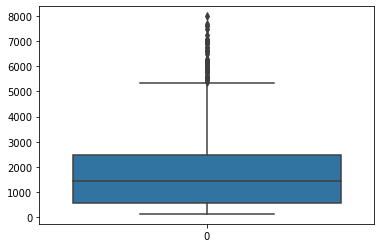

In [ ]:
ax = sns.boxplot(data=df['price'])

In [ ]:
df.describe()

,price
count,969.000000
mean,1824.450970
std,1585.271507
min,127.000000
25%,575.000000
50%,1430.000000
75%,2474.000000
max,7992.000000


видно, что основная масса товаров стоит до 2474 (75% квантиль), но есть значительно меньшее кол-во товаров с высокими ценами

это скорее всего будет портить результаты регресии

vectorization

In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [54]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [55]:
df = pd.read_csv('/content/drive/My Drive/shoes_for_regr.csv')

BoW (CountVectorizer)

сначала с дефолтными параметрами

In [56]:
cv = CountVectorizer()


X = np.concatenate((cv.fit_transform(df.lemmatized_isalpha).toarray(), 
                    df[['description_len', 'num_of_caps', 'num_of_nonalpha']].to_numpy()), 
                   axis=1)

y = df.price.values

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [58]:
X.shape

(966, 3457)

tf-idf

In [59]:
vectorizer = TfidfVectorizer()
X_tfidf = np.concatenate((vectorizer.fit_transform(df.lemmatized_isalpha).toarray(), 
                    df[['description_len', 'num_of_caps', 'num_of_nonalpha']].to_numpy()), 
                   axis=1)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, random_state=42)

In [60]:
X_tfidf.shape

(966, 3457)

In [61]:
from sklearn.linear_model import LinearRegression, Ridge

## грид серч

для ridge

In [16]:
from sklearn.model_selection import GridSearchCV

In [277]:
parameters = {'alpha': [x / 10.0 for x in range(1, 10)] + list(range(1, 20)), 
              'fit_intercept':[False, True], 
              'normalize':[False, True]}
regressor = Ridge()
reg = GridSearchCV(regressor, parameters, scoring='neg_mean_absolute_error')
reg.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19],
                         'fit_intercept': [False, True],
                         'normalize': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [278]:
print(reg.best_params_)
reg.best_score_

{'alpha': 0.8, 'fit_intercept': True, 'normalize': True}


-810.1461935445975

In [279]:

best_model = reg.best_estimator_


In [280]:
preds = best_model.predict(X_test)
print("mae", mean_absolute_error(y_test, preds))

mae 795.3367322303253


или с tfidf:

In [295]:
parameters = {'alpha': [x / 10.0 for x in range(1, 10)] + list(range(1, 20)), 
              'fit_intercept':[False, True], 
              'normalize':[False, True]}
regressor = Ridge()
reg = GridSearchCV(regressor, parameters, scoring='neg_mean_absolute_error')
reg.fit(X_train_tfidf, y_train_tfidf)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19],
                         'fit_intercept': [False, True],
                         'normalize': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [296]:
preds = reg.best_estimator_.predict(X_test_tfidf)
print("mae", mean_absolute_error(y_test_tfidf, preds))

mae 752.9069135489716


с tfidf стало немного лучше

## грид серч

для LinearRegression()

хочется проверить, что будет, если взять модель без регуляризации

In [297]:
parameters = {'fit_intercept':[False, True], 
              'normalize':[False, True]}

regressor = LinearRegression()
reg = GridSearchCV(regressor, parameters, scoring='neg_mean_absolute_error')
reg.fit(X_train, y_train)
print(reg.best_params_)
print(reg.best_score_)

{'fit_intercept': False, 'normalize': False}
-91329.8736525923


In [298]:
best_model = reg.best_estimator_

In [299]:
preds = best_model.predict(X_test)
print("mae", mean_absolute_error(y_test, preds))

mae 14099.339477567588


или с tfidf:

In [300]:
regressor = LinearRegression()
reg = GridSearchCV(regressor, parameters, scoring='neg_mean_absolute_error')
reg.fit(X_train_tfidf, y_train_tfidf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [False, True],
                         'normalize': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [301]:
preds = reg.best_estimator_.predict(X_test_tfidf)
print("mae", mean_absolute_error(y_test_tfidf, preds))

mae 5115.30575915027


просто линейная регрессия без регуляризации работает ужасно

в целом выходит, что из векторайзеров лучший - tfidf

# задание 2


Предсказать оценку товара пользователем по его отзыву (для каждого отзыва)

In [16]:
df = pd.read_csv('/content/drive/My Drive/my_shoes_data.csv')

In [17]:
df = df[['reviews', 'reviews_rating']]

In [18]:
df.head()

,reviews,reviews_rating
0,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...
1,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...
2,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...
3,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...
4,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...


In [19]:
df = df.apply(lambda x: x.str.split('\|\|').explode()).reset_index()
df = df[['reviews', 'reviews_rating']]

In [20]:
df.head(5)

,reviews,reviews_rating
0,Not happy with product,1.0 out of 5 stars
1,It's not as expected.,1.0 out of 5 stars
2,AVERAGE PRODUCT,3.0 out of 5 stars
3,Pic more beautiful,3.0 out of 5 stars
4,Got damage product. But quality is average fo...,3.0 out of 5 stars


In [21]:
df.reviews_rating = df.reviews_rating.str.strip()

In [22]:
df.reviews = df.reviews.str.strip()

In [23]:
df.reviews_rating.unique()

array(['1.0 out of 5 stars', '3.0 out of 5 stars', '2.0 out of 5 stars',
       '5.0 out of 5 stars', '4.0 out of 5 stars'], dtype=object)

препроцессинг ранее определенными функциями

In [24]:
df['without_punc'] = df['reviews'].apply(delete_trash)

In [25]:
df['review_len'] = df['without_punc'].apply(len)

df['num_of_caps'] = df['without_punc'].apply(lambda x: len([ch for ch in x if ch.isupper()]))

# num of emojis and !
df['num_of_nonalpha'] = df['without_punc'].apply(lambda x: len([ch for ch in x if not ch.isalnum() and not ch == " "]))
# isalnum - checks if every symbol is number or letter

In [26]:
df.num_of_nonalpha.unique()

array([ 0,  1,  2,  5,  3,  6,  4,  7,  8, 10, 12])

In [27]:
df.shape

(8208, 6)

In [28]:
df.drop_duplicates(inplace=True)
df.shape

(5339, 6)

лемматизация (с приведением к нижнему регистру) и стоп слова

In [39]:
# Install spaCy (run in terminal/prompt)

!pip install spacy

# Download spaCy's  'en' Model
!spacy download en

     |████████████████████████████████| 12.0 MB 10.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [56]:
df.drop(['reviews'], inplace=True, axis=1)


,reviews_rating,without_punc,review_len,num_of_caps,num_of_nonalpha,lemmatized_isalpha
0,1.0 out of 5 stars,Not happy with product,22,1,0,happy product
1,1.0 out of 5 stars,Its not as expected,19,1,0,expect


In [57]:
%%time
nlp = spacy.load('en', disable=['parser', 'ner'])
df['lemmatized_isalpha'] = df['without_punc'].apply(get_lemmas)

CPU times: user 17.7 s, sys: 101 ms, total: 17.8 s
Wall time: 17.9 s


не удаляю слова no и not

In [58]:
df.head(2)

,reviews_rating,without_punc,review_len,num_of_caps,num_of_nonalpha,lemmatized_isalpha
0,1.0 out of 5 stars,Not happy with product,22,1,0,not happy product
1,1.0 out of 5 stars,Its not as expected,19,1,0,not expect


In [60]:
df.drop(['without_punc'], inplace=True, axis=1)

сохраняю в отдельный csv

In [61]:
df.to_csv('/content/drive/My Drive/shoes_for_clf.csv', index=None)

In [2]:
import pandas as pd


In [3]:
df = pd.read_csv('/content/drive/My Drive/shoes_for_clf.csv')

надо посмотреть на распределение отзывов по классам оценок

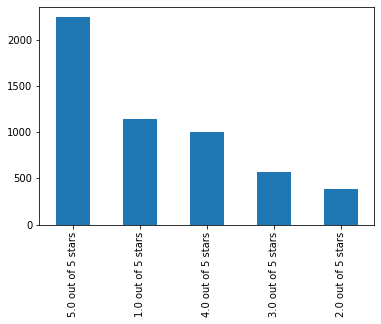

In [4]:
df['reviews_rating'].value_counts().plot.bar(x='reviews_rating', y='Counts')

классы **НЕ**сбалансированые - больше всего 5 из 5, меньше всего 2 из 5

при оценке работы алгоритмов надо будет использовать micro усреднение, чтобы несбалансированность не помешала понять результаты

In [7]:
df['lemmatized_isalpha'].replace('', np.nan, inplace=True)
df.dropna(subset=['lemmatized_isalpha'], inplace=True)

In [8]:
df.shape

(5244, 5)

на тестах с регрессией стало понятно, что tfidf работает лучше bow, поэтому я буду векторизовать только с tfidf

делаю лейблы классов от 0 до n-1

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.reviews_rating)
y = le.transform(df.reviews_rating)


векторизую тексты и делаю общую матрицу фичей

In [12]:
vectorizer = TfidfVectorizer()
X = np.concatenate((vectorizer.fit_transform(df.lemmatized_isalpha).toarray(), 
                    df[['review_len', 'num_of_caps', 'num_of_nonalpha']].to_numpy()), 
                   axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

это задача многоклассовой классификации

In [13]:
from sklearn.metrics import *

# грид серч для к соседей



In [26]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

In [27]:
parameters = {'n_neighbors': [5, 10, 20, 40]}
clf_grid = GridSearchCV(clf, parameters, scoring='f1_micro', verbose=2)
clf_grid.fit(X_train, y_train)

best_model = clf_grid.best_estimator_
predicted = best_model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.6s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=10 ..................................................
[CV] ................................... n_neighbors=10, total=   1.7s
[CV] n_neighbors=10 ..................................................
[CV] ................................... n_neighbors=10, total=   1.8s
[CV] n_neighbors=10 ..................................................
[CV] ................................... n_neighbors=10, total=   1.7s
[CV] n_neighbors=10 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   37.3s finished


In [28]:
acc = accuracy_score(predicted, y_test)
micro_f1 = f1_score(predicted, y_test, average = 'micro')
micro_p = precision_score(predicted, y_test, average = 'micro')
micro_r = recall_score(predicted, y_test, average = 'micro')

print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))


acc=0.3974
micro F1=0.3974, micro P=0.3974, micro R=0.3974


какие классы путаются?

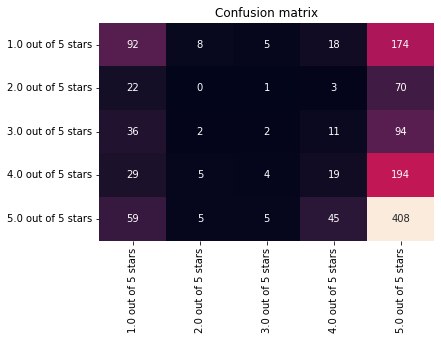

In [29]:
sns.heatmap(data=confusion_matrix(y_test, predicted), annot=True, fmt="d", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix")
plt.show()

эта модель все определяет как 5 из 5 :) несбалансированность классов в этом случае сильно мешает

# грид серч для деревьев решений



In [18]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
parameters = {'criterion': ["gini", "entropy"], 
              'splitter':['best', 'random']} # 'max_depth':[None, 5, 10]
clf = DecisionTreeClassifier()
clf_grid = GridSearchCV(clf, parameters, scoring='f1_micro', verbose=2)
clf_grid.fit(X_train, y_train)

best_model = clf_grid.best_estimator_
predicted = best_model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] criterion=gini, splitter=best ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... criterion=gini, splitter=best, total=   0.8s
[CV] criterion=gini, splitter=best ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .................... criterion=gini, splitter=best, total=   1.0s
[CV] criterion=gini, splitter=best ...................................
[CV] .................... criterion=gini, splitter=best, total=   1.0s
[CV] criterion=gini, splitter=best ...................................
[CV] .................... criterion=gini, splitter=best, total=   0.8s
[CV] criterion=gini, splitter=best ...................................
[CV] .................... criterion=gini, splitter=best, total=   0.8s
[CV] criterion=gini, splitter=random .................................
[CV] .................. criterion=gini, splitter=random, total=   1.5s
[CV] criterion=gini, splitter=random .................................
[CV] .................. criterion=gini, splitter=random, total=   1.3s
[CV] criterion=gini, splitter=random .................................
[CV] .................. criterion=gini, splitter=random, total=   1.1s
[CV] criterion=gini, splitter=random .................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   22.4s finished


In [21]:
acc = accuracy_score(predicted, y_test)
micro_f1 = f1_score(predicted, y_test, average = 'micro')
micro_p = precision_score(predicted, y_test, average = 'micro')
micro_r = recall_score(predicted, y_test, average = 'micro')

print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))


acc=0.4630
micro F1=0.4630, micro P=0.4630, micro R=0.4630


## confusion matrix

какие классы путаются?

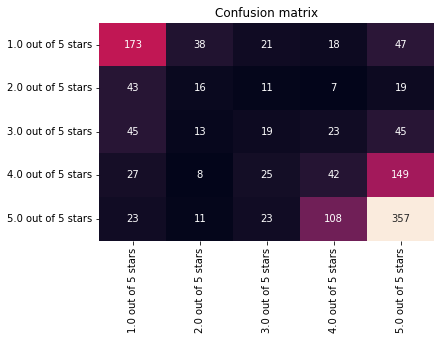

In [24]:
sns.heatmap(data=confusion_matrix(y_test, predicted), annot=True, fmt="d", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix")
plt.show()

только 1 из 5 и 5 из 5 нормально распознаются, с остальными классами все очень плохо

чтобы улучшить результат стоит 1) сбалансировать классы 2) попробовать другие модели классификации 3) добавить фичи про эмоционально окрашенные слова aka sentiment analysis


в обоих заданиях качество не очень

у регрессии это может быть связано скорее всего с тем, что присутствуют выбросы, а у классификации - дисбаланс классов. возможно, нужны дополнительные фичи, например какая-то синтаксическая инфа